In [2]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from diffusion_equation import compute_solution
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

# Data from simulator

In [3]:
# # 5000
# sim_data = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/sim_5000.txt", dtype=np.float32)
# x_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/x_5000.txt", dtype=np.float32)
# y_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/y_5000.txt", dtype=np.float32)
# t_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/t_5000.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list
# 5000 3sigma
sim_data = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/sim_5000.txt", dtype=np.float32)
x_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/x_5000.txt", dtype=np.float32)
y_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/y_5000.txt", dtype=np.float32)
t_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/t_5000.txt", dtype=np.float32)
sim_data, x_list, y_list, t_list

(array([[ 4.3199003e-02,  6.6181231e-01,  3.3818772e-01],
        [ 1.4108596e-03,  3.6187479e-01,  6.3812524e-01],
        [ 3.3429716e-02,  5.5602217e-01,  4.4397783e-01],
        ...,
        [ 5.5982126e-03,  5.3862143e-01,  4.6137860e-01],
        [ 3.5300122e-03,  4.2821646e-01,  5.7178354e-01],
        [ 5.1515096e-01,  1.1274540e+01, -1.0274540e+01]], dtype=float32),
 array([10., 46., 14., ..., 19., 45.,  0.], dtype=float32),
 array([13., 28., 15., ..., 21., 27.,  8.], dtype=float32),
 array([4374., 4597., 2804., ..., 4569.,  648.,  248.], dtype=float32))

In [4]:
perm = np.load('/Users/kirill/edu/3course/PINN_project/TwoPhase2/perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))
t_final = 3.0
niter = 5000
dt = t_final / niter

In [5]:
dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

x = np.array(x_list * dx0)
y = np.array(y_list * dx1)
t = np.array(t_list * dt)

pwat1 = 2.0 * np.ones_like(x)
poil1 = 4.0 * np.ones_like(x)
kwat1 = 1.0 * np.ones_like(x)
koil1 = 0.3 * np.ones_like(x)

points = np.stack((t, x, y), -1)
points, sim_data

(array([[2.6244001 , 0.19999999, 0.43333337],
        [2.7582002 , 0.91999996, 0.9333334 ],
        [1.6824001 , 0.28      , 0.5       ],
        ...,
        [2.7414002 , 0.38      , 0.70000005],
        [0.38880002, 0.9       , 0.90000004],
        [0.1488    , 0.        , 0.26666668]], dtype=float32),
 array([[ 4.3199003e-02,  6.6181231e-01,  3.3818772e-01],
        [ 1.4108596e-03,  3.6187479e-01,  6.3812524e-01],
        [ 3.3429716e-02,  5.5602217e-01,  4.4397783e-01],
        ...,
        [ 5.5982126e-03,  5.3862143e-01,  4.6137860e-01],
        [ 3.5300122e-03,  4.2821646e-01,  5.7178354e-01],
        [ 5.1515096e-01,  1.1274540e+01, -1.0274540e+01]], dtype=float32))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    points, sim_data, test_size=0.33, random_state=42)

# Initialazing XGBoost model

In [7]:
xgb_regressor = xgb.XGBRegressor(tree_method='hist', verbosity=2)
multioutput_regressor = MultiOutputRegressor(xgb_regressor)
multioutput_regressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [8]:
mean_squared_error(multioutput_regressor.predict(X_train), y_train)

0.002137991

In [9]:
mean_squared_error(multioutput_regressor.predict(X_test), y_test)

0.27760527

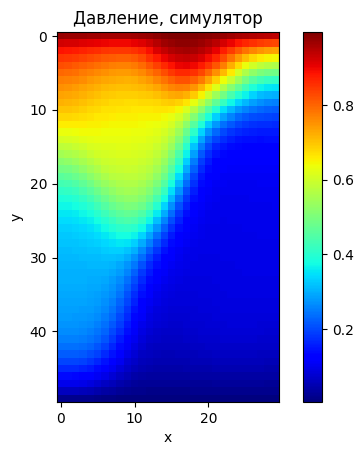

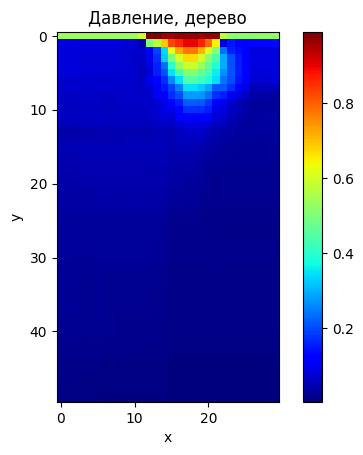

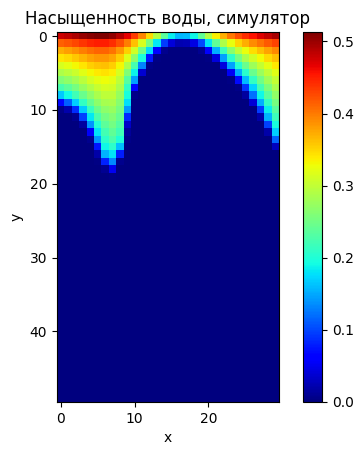

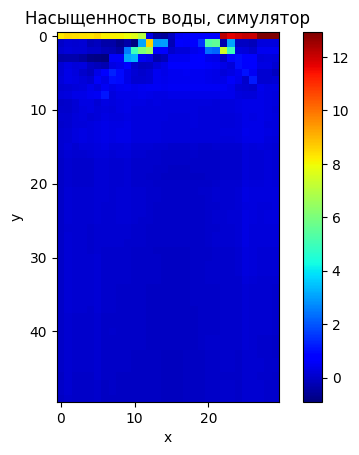

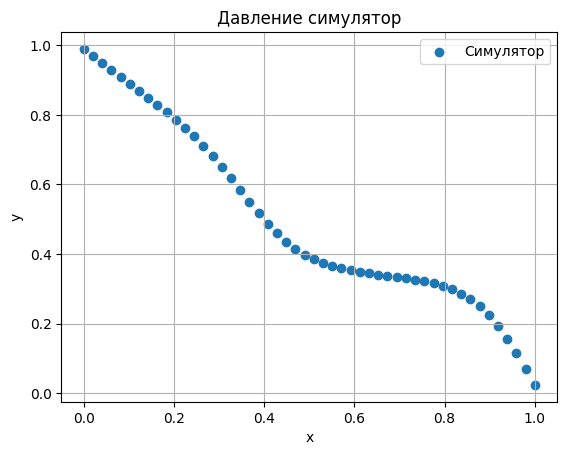

In [14]:
# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3
# pmin = 0.0
# pmax = 1.0
# nx0 = 50
# nx1 = 30
# nx2 = 1
# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2
# dt = 5.0e-7
# niter = 1000

# poro = 0.1 + np.zeros((nx0, nx1, nx2))
# perm = np.load('/Users/kirill/edu/3course/PINN_project/TwoPhase2/perm.npy')
# perm = np.reshape(perm, (nx0, nx1, nx2))

# pres, swat, soil = compute_solution(perm, poro,
#                                     dx0, dx1, dx2, dt * niter, niter,
#                                     pwat, kwat, poil, koil, vr,
#                                     pmin=0.0, pmax=1.0)

time_for_model = (niter * dt) * np.ones(1500)
x_for_model = dx0 * torch.arange(50)
y_for_model = dx1 * torch.arange(30)
#     cartesian_points = np.transpose([np.tile(x_for_model, len(y_for_model)), 
#                                      np.repeat(y_for_model, len(x_for_model))])
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
cartesian_points = cartesian_points.detach().numpy()
model_prediction = multioutput_regressor.predict(np.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))


plt.figure()
plt.title('Давление, симулятор')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('color_pres_sim.png')
plt.show()

plt.figure()
plt.title('Давление, дерево')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()



plt.figure()
plt.title('Насыщенность воды, симулятор')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.title('Насыщенность воды, симулятор')
plt.imshow(model_prediction[:, 1].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()



plt.figure()
plt.title('Давление симулятор')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, 3], label='Симулятор')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [22]:
def main2000(model):
    print('inside the main function')

    pwat = 2.0
    poil = 4.0
    vr = 0.3
    kwat = 1.0
    koil = 0.3

    # pwat = 1.0
    # poil = 1.0
    # vr = 1.0
    # kwat = 1.0
    # koil = 1.0
    pmin = 0.0
    pmax = 1.0
    nx0 = 50
    nx1 = 30
    nx2 = 1
    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    dt = 0.26e-1
    niter = 100

    poro = 0.1 + np.zeros((nx0, nx1, nx2))
    perm = np.ones((nx0, nx1, nx2))
    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * np.ones(1500)
    x_for_model = dx0 * torch.arange(50)
    y_for_model = dx1 * torch.arange(30)
#     cartesian_points = np.transpose([np.tile(x_for_model, len(y_for_model)), 
#                                      np.repeat(y_for_model, len(x_for_model))])
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    cartesian_points = cartesian_points.detach().numpy()
    model_prediction = model.predict(np.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))

        
    plt.figure()
    plt.title('Давление, симулятор')
    plt.imshow(pres)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pres_sim.png')
    plt.show()
    
    plt.figure()
    plt.title('Давление, модель')
    plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pres_pinn.png')
    plt.show()




    return 0